In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from pytorch_lightning import Trainer
import os
import numpy as np
import pandas as pd
from os.path import join
from typing import Optional
from config import processed_data_path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import wasserstein_distance 
import joblib
import optuna
%matplotlib inline
from matplotlib import pyplot as plt
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import r2_score
from scipy.stats import wasserstein_distance
import threading
import concurrent
from sklearn.metrics import r2_score
from zStudy_R2 import VAE, _dataset, compare_integer, compare_continuous
from os.path import join, basename, exists
from os import getcwd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,precision_score
import pickle
from math import log10, floor
import gc
import sqlite3

In [2]:
# For saving img
dir_name = basename(getcwd())
img_dir = join(getcwd(), "images")
if not exists(img_dir):
    os.mkdir(img_dir)
variante= 'R2'
dir_name

'z_study'

In [3]:
def round_sig(x, sig=2):
    # rounds to significant digits
   return round(x, sig-int(floor(log10(abs(x))))-1)

## Loading the Study

In [4]:
#Load bkg data
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
#bkg_name = bkg['name']
bkg_weights = bkg['weights']
bkg.drop(columns=['weights', 'name'], inplace=True)

# Get bkg shapes etc
bkg_shape = bkg.shape
bkg_columns = bkg.columns
bkg = bkg.to_numpy(dtype=np.float32)
bkg_weights = bkg_weights.to_numpy(dtype=np.float16)

# Get database names
con = sqlite3.connect("optimization.db")
cursor = con.cursor()

cursor.execute("SELECT * FROM studies")
names = [x[1] for x in cursor.fetchall() if variante in x[1]]
names = sorted(names, key=lambda x: int(x.split("-")[1].replace(' zdim ', '').replace(' ', '')))
del con, cursor
gc.collect()

# Define variablers
book = {}
book["x_axis"] = []
book["r2"] = []
book["wd"] = []
book["means"] = []
book["stds"] = []
book["correlations"] = []

# Let's have 10 samples of each data point
num_runs = 10 


# Get data

## Means, stds, r2s, wds

In [5]:
for n in tqdm(range(num_runs)):
    book["means"].append([])
    book["stds"].append([])
    book["wd"].append([])
    book["r2"].append([])
    book["correlations"].append([])
    for i,name in tqdm(enumerate(names), total=len(names)):
        zdim = int(name.split("-")[1].replace(' zdim ', '').replace(' ', ''))
        #print("Zdim:", zdim)

        study = optuna.load_study(study_name=name, storage="sqlite:///optimization.db")
        
        trial = study.best_trial
        

        # load model
        model = VAE.load_from_checkpoint(
            join('models', f"{variante.lower()}_zStudy-zdim_{zdim}_trial_{trial.number}.ckpt"),
            trial = optuna.trial.FixedTrial(trial.params), 
            zdim = zdim,
            dataset = "bkg", 
            batch_size=512)

        model.eval()
        

        ## Sample from the model
        # Random sample from N(0,1)
        sample = model.decode(torch.rand(bkg_shape[0], zdim)).detach().numpy()

        # Calculate WD Score
        objective_score = 0
        for idx in range(bkg_shape[1]):
            feature = bkg_columns[idx]
            if "Tag" in feature or "Multi" in feature:
                #print("Feature", feature, "é inteiro")
                objective_score += compare_integer(bkg[:, idx], bkg_weights, sample[:, idx], np.ones(bkg_weights.shape))
            else:
                #print("Feature", feature, "é continuo")
                objective_score += compare_continuous(bkg[:, idx], bkg_weights, sample[:, idx], np.ones(bkg_weights.shape))

        del sample, study, trial
        gc.collect()

        # Calculate R2 Score
        x_out, hidden = model.test_step(torch.from_numpy(bkg))
        hidden = hidden.detach().numpy()
        x_out = x_out.detach().numpy()
        r2_score_ = r2_score(bkg, x_out, sample_weight=bkg_weights)
        del x_out
        gc.collect()

        # Calculate hidden mean
        total_mean = []
        total_std = []
        for x in range(hidden.shape[1]):
            total_mean.append(hidden[:, x].mean())
            total_std.append(hidden[:, x].std())
        mean = np.array(total_mean).mean()
        std = np.array(total_std).mean()

        # Correlations
        corr = pd.DataFrame(hidden).corr().apply(abs)
        corr.replace(1, 0, inplace=True)        
        
        # Storing values

        book["means"][-1].append(round(abs(mean),6))
        book["stds"][-1].append(round(std,6))
        book["wd"][-1].append(round(objective_score,6))
        book["r2"][-1].append(round(r2_score_,6))
        book["correlations"][-1].append(round(corr.mean().mean(), 5))

        del hidden, model, mean, std
        gc.collect()

del bkg, bkg_columns, bkg_shape, bkg_weights
gc.collect()

# Save book
pickle.dump( book, open(variante+"_book.p", "wb" ) )

## Rocs

In [ ]:
bkg = _dataset(category='validation',variant='bkg').all_data() # The data category is validation because I accidentally used 'test' on the validation step while training
signal = _dataset(category='all',variant='signal').all_data()

data = pd.concat([signal, bkg])
del signal, bkg


rocs = {}

for n in tqdm(range(num_runs)):
    features = list(data['name'].unique())
    distributions = {}

    for name in features:
        name = name.replace('.h5', '')
        if name not in rocs.keys():
            rocs[name] = []
        rocs[name].append([])

    for i,name in tqdm(enumerate(names), total=len(names)):
        zdim = int(name.split("-")[1].replace(' zdim ', '').replace(' ', ''))

        study = optuna.load_study(study_name=name, storage="sqlite:///optimization.db")
        trial = study.best_trial
        model = VAE.load_from_checkpoint(
            join('models', f"{variante.lower()}_zStudy-zdim_{zdim}_trial_{trial.number}.ckpt"),
            trial = optuna.trial.FixedTrial(trial.params), 
            zdim = zdim,
            dataset = "bkg", 
            batch_size=512)

        model.eval()

        for x in features:

            ## Get the relevant data
            sData = data.loc[data['name'] == x].drop(columns=['name', 'weights'])
            sData = torch.from_numpy(
                sData.to_numpy(dtype=np.float32)
            )

            ## Pass input through model to get the output
            output, _ = model.test_step(sData)

            ## Calculate the error dist
            error_dist = (sData - output)**2
            del output, sData
            gc.collect()
            error_dist = error_dist.detach().numpy().sum(axis=1)
            error_dist = np.log(error_dist)
            # Append to list
            distributions[x] = error_dist

        del model, trial, study, error_dist
        gc.collect()

        ## Normalize the distributions
        # This way all values should be between 0 and 1
        # x transform
        min_of_dist = min(map(lambda x: min(x), distributions.values()))
        for x in distributions:
            distributions[x] = distributions[x] - min_of_dist
        # scale
        max_of_dist = max(map(lambda x: max(x), distributions.values()))
        for x in distributions:
            distributions[x] = distributions[x] / max_of_dist

        for x in distributions.keys():
            if x != 'bkg.h5':
                # Set labels
                bkg_labels = np.zeros(distributions['bkg.h5'].shape[0]).astype(int)
                signal_labels = np.ones(distributions[x].shape[0]).astype(int)
                labels = np.concatenate([bkg_labels, signal_labels])

                # Set Scores
                score = np.concatenate([distributions['bkg.h5'], distributions[x]]) 

                # Set weights
                weights = pd.concat([
                                    data[data['name'] == "bkg.h5"]['weights'], 
                                    data[data['name'] == x]['weights']
                                    ])

                name = x.replace('.h5', '')
                if name not in rocs.keys():
                    rocs[name] = []

                
                rocs[name][-1].append(roc_auc_score(y_true=labels, y_score=score,sample_weight=weights))

del distributions, weights
gc.collect()
# Save rocs
pickle.dump( rocs, open(variante+"_rocs.p", "wb" ) )


In [ ]:
# Load pickles
book = pickle.load( open( variante+"_book.p", "rb" ) )
rocs = pickle.load( open( variante+"_rocs.p", "rb" ))

## Plot data

In [ ]:
ignore = []
for x in wd:
    ignore.append(x[0])



In [ ]:
book["x_axis"] = [x for x in range(5, 105, 5)]

<ipython-input-85-18232a9770c4>:25: UserWarning:

You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.

<ipython-input-85-18232a9770c4>:26: UserWarning:

You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.



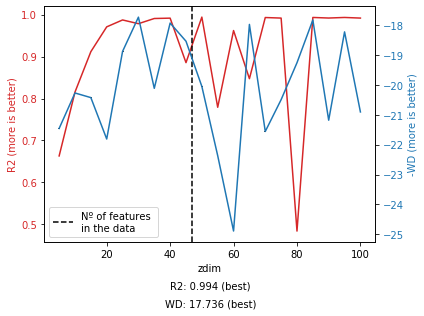

In [ ]:
fig, ax1 = plt.subplots()

# PLOT R2
color = 'tab:red'
ax1.set_xlabel('zdim')
ax1.set_ylabel('R2 (more is better)', color=color)
r2 = np.array(book['r2'])
r2_y = np.mean(r2, axis=0)
#ax1.plot(book["x_axis"], np.mean(r2, axis=0), color=color)
ax1.errorbar(book["x_axis"], r2_y, yerr=(np.max(r2, axis=0)-r2_y, r2_y-np.min(r2, axis=0)), ecolor="black", color=color)
ax1.tick_params(axis='y', labelcolor=color)

# PLOT WD
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('-WD (more is better)', color=color)  # we already handled the x-label with ax1
wd = np.array(book['wd'])
wd_y = np.mean(wd, axis=0)
#ax2.plot(book["x_axis"], -np.mean(wd, axis=0), color=color)
ax2.errorbar(book["x_axis"], -wd_y, yerr=(np.max(wd, axis=0)-wd_y, wd_y-np.min(wd, axis=0)), ecolor="black", color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.annotate(f'R2: {str(round_sig(r2.max(),5))} (best)', (0.5,-0.2), xycoords='axes fraction', textcoords='offset points', ha='center')
plt.annotate(f'WD: {str(round_sig(wd.min(),5))} (best)', (0.5,-0.275), xycoords='axes fraction', textcoords='offset points', ha='center')
plt.axvline(47, ymin=0, ymax=1, color="black", linestyle='--', label="Nº of features \nin the data")
plt.legend(loc='best')
fig.savefig(join(img_dir, dir_name+variante+"_r2_wd.png"), bbox_inches = 'tight')
plt.show()

<ipython-input-93-d8b0629c8266>:25: UserWarning:

You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.

<ipython-input-93-d8b0629c8266>:26: UserWarning:

You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.



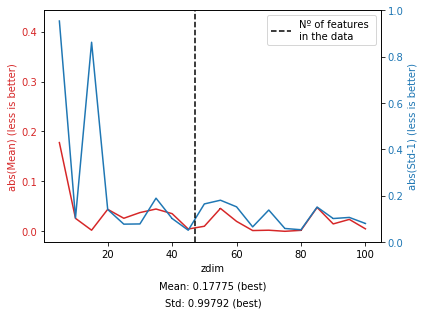

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('zdim')
ax1.set_ylabel('abs(Mean) (less is better)', color=color)
#ax1.plot(book["x_axis"], means, color=color)
means = np.array(book['means'])
means_y = np.mean(means, axis=0)
ax1.errorbar(book["x_axis"], means_y, yerr=(np.max(means, axis=0)-means_y, means_y-np.min(means, axis=0)), ecolor="black", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('abs(Std-1) (less is better)', color=color)  # we already handled the x-label with ax1
#ax2.plot(book["x_axis"], [abs(x-1) for x in stds], color=color)
stds = np.array(book['stds'])
stds_ = abs(1-stds)
stds_y = [abs(x-1) for x in np.mean(stds, axis=0)]
ax1.errorbar(book["x_axis"], stds_y, yerr=(np.max(stds_, axis=0)-stds_y, stds_y-np.min(stds_, axis=0)), ecolor="black", color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.annotate(f'Mean: {str(round_sig(means.max(),5))} (best)', (0.5,-0.2), xycoords='axes fraction', textcoords='offset points', ha='center')
plt.annotate(f'Std: {str(round_sig(min(list(stds.reshape(-1)), key=lambda x:abs(x-1)),5))} (best)', (0.5,-0.275), xycoords='axes fraction', textcoords='offset points', ha='center')
plt.axvline(47, ymin=0, ymax=1, color="black", linestyle='--', label="Nº of features \nin the data")
plt.legend(loc='best')
fig.savefig(join(img_dir, dir_name+variante+"_mean_std.png"), bbox_inches = 'tight')
plt.show()

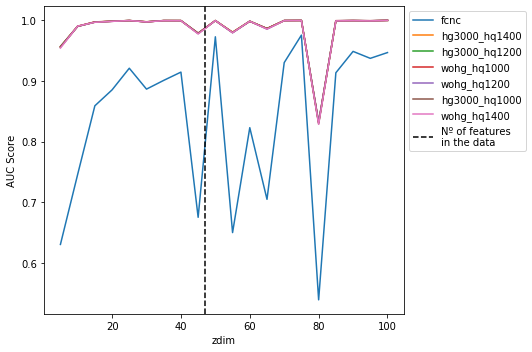

In [ ]:
fig, ax = plt.subplots(figsize=(7.5,5))
try:
    rocs.pop("bkg")
except:
    pass

for key in rocs.keys():
    ax.set_xlabel('zdim')
    ax.set_ylabel('AUC Score')
    auc_score = np.array(rocs[key])
    auc_score_y = np.mean(auc_score, axis=0)
    ax.plot([x for x in range(5, 104, 5)], auc_score_y, label=key)
    #ax.errorbar(book["x_axis"], auc_score_y, yerr=(np.max(auc_score, axis=0)-auc_score_y, auc_score_y-np.min(auc_score, axis=0)), ecolor="black", label = key)


plt.axvline(47, ymin=0, ymax=1, color="black", linestyle='--', label="Nº of features \nin the data")
plt.legend(loc='best', ncol=1, bbox_to_anchor=(1, 1))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.savefig(join(img_dir, dir_name+variante+"_aucScores.png"), bbox_inches = 'tight')
plt.show()

In [ ]:
np.max(auc_score, axis=0)-auc_score_y

array([2.84681855e-05, 4.65171540e-05, 1.20489663e-05, 1.57118115e-05,
       5.40987227e-06, 1.69714382e-05, 3.93154681e-06, 3.97556612e-06,
       2.72505202e-05, 9.22819769e-06, 5.69180043e-05, 9.49230758e-06,
       1.48217960e-05, 7.18789896e-06, 9.44854998e-06, 1.14675885e-04,
       2.22698199e-05, 7.25736275e-06, 1.16228277e-05, 4.05584886e-06])

In [ ]:
np.std(auc_score, axis=0)

array([1.69685164e-05, 2.98885276e-05, 7.62960096e-06, 7.39565522e-06,
       2.41841160e-06, 1.01704240e-05, 2.26188732e-06, 2.65112991e-06,
       1.56560440e-05, 5.47635239e-06, 3.94092956e-05, 4.22088500e-06,
       1.05504561e-05, 3.56701449e-06, 9.36518164e-06, 7.99106759e-05,
       1.08552170e-05, 4.18762040e-06, 6.25657207e-06, 3.96504540e-06])

## Sanity check

In [ ]:
num_trials = []
for i,name in tqdm(enumerate(names), total=len(names)):
    zdim = int(name.split("-")[1].replace(' zdim ', '').replace(' ', ''))

    study = optuna.load_study(study_name=name, storage="sqlite:///optimization.db")
    num_trials.append(len(study.trials))
    
fig, ax = plt.subplots()

ax.set_xlabel('zdim')
ax.set_ylabel('')
ax.plot(book["x_axis"], num_trials, label='Num. Trials')

ax.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()